In [3]:
using Plots
using Interact
using Statistics
using StatsBase
using CSV, Tables

## Exercise 1: Moving in 2D

In [4]:
# 1. Define an abstract type AbstractWalker.
abstract type AbstractWalker end

In [5]:
# 2. Define an abstract type Abstract2DWalker that is a subtype of AbstractWalker (using <:).
abstract type Abstract2DWalker <: AbstractWalker end

In [6]:
# 3. Define an immutable type Location that contains integers x and y.
struct Location
    x::Int64
    y::Int64
end

In [7]:
# 4. Define a Walker2D type that is a subtype of AbstractWalker2D. It should contain a field position that is 
#    a Location object.
mutable struct Walker2D <: Abstract2DWalker
    position::Location
end

In [8]:
# 5. Check that Julia automatically provides a constructor function Walker2D(position) that accepts an object 
#    of type Location. Construct a Walker located at the origin.
@show methods(Walker2D)
Walker = Walker2D(Location(0, 0))

methods(Walker2D) = # 2 methods for type constructor:
[1] Walker2D(position::Location) in Main at In[7]:4
[2] Walker2D(position) in Main at In[7]:4


Walker2D(Location(0, 0))

In [9]:
# 6.Write a new method of the constructor for Walker2D that accepts two integers, $x$ and $y$, i.e. 
#   Walker2D(x, y).
Walker2D(x, y) = Walker2D(Location(x, y))
# @show methods(Walker2D)

Walker2D

In [10]:
# 7. Write a function make_tuple that takes an object of type Location and returns the corresponding tuple (x, y).
function make_tuple(l::Location)
    return (l.x, l.y)
end

make_tuple (generic function with 1 method)

#### In the following questions, the functions should take an object of type AbstractWalker2D (or you can just leave them untyped).

In [11]:
# 8. Write a getter function pos that returns the position as a Location object.
pos(w::Abstract2DWalker) = w.position

pos (generic function with 1 method)

In [12]:
# 9. Write a setter function set_pos! that sets the position to a given location l.
function set_pos!(w::Abstract2DWalker, l::Location)
    w.position = l
end

set_pos! (generic function with 1 method)

In [13]:
# 10. Write a function jump that returns a possible new position for a walker after a 2D jump as a Location 
# object. This function should not modify its argument, and hence does not have a ! in its name. Jumps are 
# equally likely in the directions right, up, left and down.A nice way to implement this is to make a tuple 
# neighbours of possible destinations.
function jump(w::Abstract2DWalker)
    neighbours =  (
                  Location(pos(w).x, pos(w).y+1), #up
                  Location(pos(w).x+1, pos(w).y), #right
                  Location(pos(w).x, pos(w).y-1), #down
                  Location(pos(w).x-1, pos(w).y)  #left
                  ) 
    return rand(neighbours)
end

jump (generic function with 1 method)

In [14]:
# 11. Write a function jump! that moves a walker to a new position. What arguments does the function need? 
#     Use your jump function to write jump!.
function jump!(w::Abstract2DWalker)
    set_pos!(w, jump(w))
end

jump! (generic function with 1 method)

In [15]:
# 12. Write a function trajectory that calculates a trajectory of a 2D walker of length $N$.
function trajectory(w::Abstract2DWalker, N)
    points = [pos(w)]
    for i in 1:N
        jump!(w)
        push!(points, pos(w))
    end
    return points
end

trajectory (generic function with 1 method)

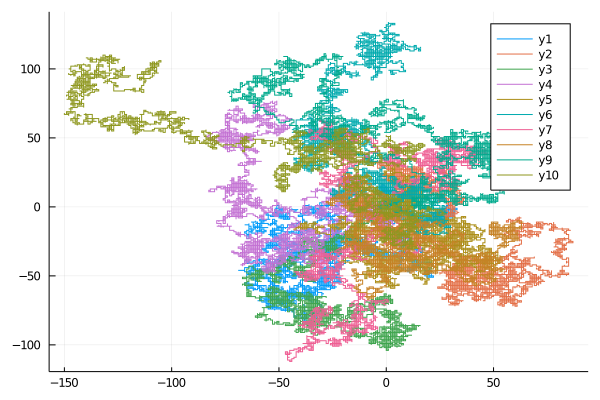

In [16]:
# 13. Plot 10 trajectories of length 10,000 on a single figure, all starting at the origin
p = plot(fmt=:png)
steps = 10000
for num_trajectory in 1:10
    Walker = Walker2D(Location(0, 0))
    plot!(make_tuple.(trajectory(Walker, steps)))
end

p
#jump!(Walker)

## Exercise 2: Making agents move

In this exercise we will combine our Agent type from Problem Set 3 with the 2D random walker that we just created, by adding a position to the Agent type.

In [17]:
# 1. Define a mutable type Agent that is a subtype of AbstractWalker2D from Exercise 1, since it will behave like 
#    a random walker and lives in 2D. Agent should contain a position of type Location, as well as a state of type 
#    InfectionStatus. (For simplicity we will not require a num_infected field, but feel free to do so if you 
#    would like.)

# From P.S. 3
@enum InfectionStatus S I R

mutable struct Agent <: Abstract2DWalker
    position::Location
    status::InfectionStatus
    num_infected::Int
end

In [18]:
# 2. Agents live in a box of side length L, centered at the origin. We need to decide (i.e. model) what happens 
#    when they reach the walls of the box (boundaries), i.e. what kind of boundary conditions to use.
#    One type of boundary condition that is relatively simple to implement are reflecting boundary conditions, 
#    as follows:
#    Each side of the box is a reflective mirror. We can model this using "bounce-back": if the particle tries 
#    to jump beyond one of the boundaries, it hits a springy wall and bounces back to the same position that 
#    it started from. That is, it proposes to take a step, but "realises" that it is blocked in that direction, 
#    so just stays where it is instead for that step.
#    Use the jump function from before (that proposes a new position) inside a new method of the jump 
#    function for an Agent that also accepts a size L and implements reflecting boundary conditions. It returns 
#    a Location object representing the new position (inside the grid).

function jump(agent::Agent, L)
    proposed_position = jump(agent)
    if ((abs(proposed_position.x) > L/2) | (abs(proposed_position.y) > L/2))
        return pos(agent)
    else
        return proposed_position
    end
end

jump (generic function with 2 methods)

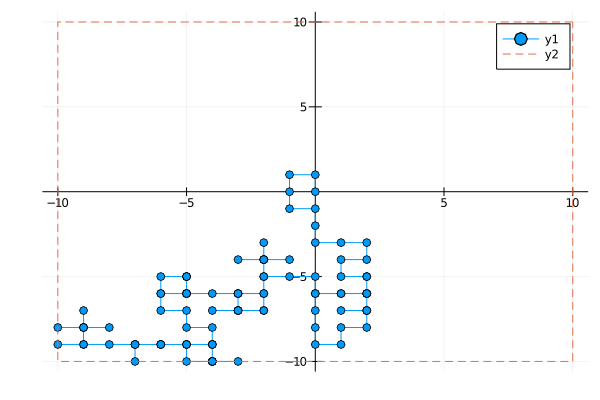

In [19]:
# 3. Check that this is working by drawing a trajectory of an Agent inside a square box of side length 20, 
#    using your function trajectory from Exercise 1.
#    You should draw the boundaries of the box and also a trajectory that is sufficiently long to see what 
#    happens at the boundary, but not so long that it fills up the box.

# don't we need to define jump! and trajectory functions with L parameter??
function jump!(w::Abstract2DWalker, L)
    set_pos!(w, jump(w, L))
end

function trajectory(w::Abstract2DWalker, N, L)
    points = [pos(w)]
    for i in 1:N
        jump!(w, L)
        push!(points, pos(w))
    end
    return points
end

ag = Agent(Location(0, 0), S, 0)
p = plot(fmt=:png, framestyle = :origin)
plot!(make_tuple.(trajectory(ag, 100, 20)), m=:o)
plot!([(10, 10), (-10, 10), (-10, -10), (10, -10), (10, 10)], linestyle=:dash)
p

## Exercise 3: Spatial epidemic model -- Initialization and visualization

We now have all of the technology in place to simulate an agent-based model in space!

For simplicity we will impose in the model that there is at most one agent on each site at all times, modelling the fact that two people cannot be in the same place as each other.

We thus begin by creating an initial condition for $N$ agents that satisfies this. Later we must make sure that the dynamics also respects this.

In [20]:
# 1. Write a function initialize that takes parameters $L$, the side length of the square box where the agents 
#    live, and $N$, the number of agents.
#    It should build, one by one, a collection of agents, by proposing a position for each one and checking if 
#    that position is occupied. If the position is occupied, it should generate another one, and so on until it 
#    finds a free spot.
#    You may create additional functions to help with this if you find it useful to do so.
#    The agents should all have initial status S, except for one of them, e.g. the first in the list, which has 
#    initial status I -- i.e. it is the only source of infection.
#    It should return the Vector of Agents.

function is_position_occupied(np::Location, a::Vector{Agent})
    if np in pos.(a)
        return true
    else 
        return false
    end
end

function find_agent_with_pos(p::Location, a::Vector{Agent})
    for i in 1:length(a)
        if p == pos(a[i])
            return i
        end
    end
    return 0
end

function initialize(L, N)
    agents = Agent[]
    for i in 1:N
        infection_status = S
        if i == 1
            infection_status = I
        end 
        proposed_position = Location(rand(-L/2:L/2), rand(-L/2:L/2))
        while is_position_occupied(proposed_position, agents)
            proposed_position = Location(rand(-L/2:L/2), rand(-L/2:L/2))
        end
        ag = Agent(proposed_position, infection_status, 0)
        push!(agents, ag)
    end
    return agents
end
    

initialize (generic function with 1 method)

In [21]:
# Test vector initialize 
#agents = Agent[]

# function is_position_occupied_test(np::Location, a::Vector{Agent})
#     if np in pos.(a)
#         return true
#     else 
#         return false
#     end
# end

# is_position_occupied_test(Location(0, 0), agents)

In [22]:
# 2. Run your initialization function for $L=10$ and $N=20$.
L=10
N=20
initialize(L, N);

In [23]:
# 3. Write a function visualize_agents that takes in a collection of agents as argument. It should plot a 
#    point for each agent, coloured according to its status.
#    You can use the keyword argument c=cs inside your call to the plotting function to set the colours of 
#    points to a vector of integers called cs. Don't forget to use ratio=1.

function visualize_agents(agents::Vector{Agent}, p)
    cs = map(ag->Int64(ag.status), agents)
    scatter!(make_tuple.(pos.(agents)), ratio=1, c=cs, leg=false) #ratio=1???
end

visualize_agents (generic function with 1 method)

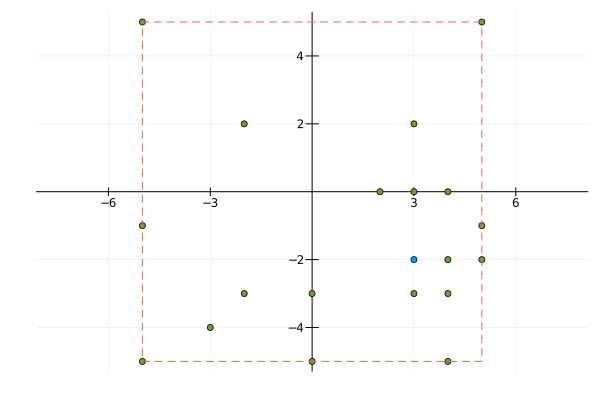

In [24]:
# 4. Run the function to visualize the initial condition you created.
x = initialize(L, N)
p = plot(fmt=:png, framestyle = :origin)
visualize_agents(x, p)
plot!([(L/2, L/2), (-L/2, L/2), (-L/2, -L/2), (L/2, -L/2), (L/2, L/2)], linestyle=:dash)

## Exercise 4: Spatial epidemic model -- Dynamics

In [25]:
# 1. Write a function step! that does one step of the dynamics of the model. It takes as parameters $L$, $p_I$ 
# and $p_R$. This combines what we did in the last Problem Set with the 2D random walker above.

#    The rules are as follows:
#    - A single agent is chosen at random; call it agent $i$.
#    - A new position is proposed for that agent.
#    - If that new position is not occupied, the agent moves there.
#    - If the new position is occupied, by agent $j$, then neither of them move, but they interact via the 
#      following rule:
#         - If agent $i$ is infected and agent $j$ is susceptible then agent $j$ becomes infected with 
#           probability $p_I$.
#         - If agent $i$ is infected, it recovers with probability $p_R$.

# event with probability p
bernouli(p) = rand() < p

function step!(agents::Vector{Agent}, L, p_I, p_R)

    N = length(agents)
    i = rand(1:N)
    agent_i = agents[i]
    proposed_position = jump(agent_i, L)
    if is_position_occupied(proposed_position, agents)
        j = find_agent_with_pos(proposed_position, agents)
        if (agents[i].status == I) & (agents[j].status == S) & (bernouli(p_I))
            agents[j].status = I
            agents[i].num_infected += 1
        end
        if (agents[i].status == I) & bernouli(p_R)
            agents[i].status = R
        end   
    else
        set_pos!(agent_i, proposed_position)
        agents[i] = agent_i
    end
        
    return agents
end

step! (generic function with 1 method)

In [26]:
# 2. Make a small system and run the step! function a few times to check (by eye) that it's doing the right thing.
L=10
N=20
x = initialize(L, N);
p_I = 0.1
p_R = 0.01

step!(x, L, p_I, p_R);

In [27]:
# 3. Make an interactive visualization to display the agents after each step, to again check 
#    visually that the implementation is correct.
@manipulate for t in slider(1:100, value=1)
    p = plot(fmt=:png, framestyle = :origin)
    plot!([(L/2, L/2), (-L/2, L/2), (-L/2, -L/2), (L/2, -L/2), (L/2, L/2)], linestyle=:dash)
    visualize_agents(step!(x, L, p_I, p_R), p)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 100,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
1, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/jeenuthomas/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/jeenuthomas/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/jeenuthomas/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/Users/jeenuthomas/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/Users/jeenuthomas/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000109655690, Task (runnable) @0x0000000109655690), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\"

In [28]:
# 4. Write a function sweep! that takes the relevant parameters and performs one sweep, i.e. $N$ steps.

# sweep is allowing for N steps, N=length of vector
function sweep!(agents::Vector{Agent}, L, p_I, p_R) 
    for i in 1:length(agents)
        step!(agents, L, p_I, p_R)
    end
    return agents
end
#sweep!(x, L, p_I, p_R,)

sweep! (generic function with 1 method)

In [29]:
# 5. Write a function dynamics! that takes the same parameters as step!, together with a number of sweeps.
#    Run the dynamics for the given number of sweeps.
#    Save the state of the whole system, together with the total numbers of $S$, $I$ and $R$ individuals, 
#    after each sweep, for later use.
#   You may need the function deepcopy to copy the state of the whole system.

function dynamics!(agents::Vector{Agent}, L, p_I, p_R, n_sweeps)
    state = []
    Ss = []
    Is = []
    Rs = []
    
    push!(state, deepcopy(agents))
    dict = countmap([i.status for i in agents])
    if haskey(dict, S) push!(Ss, dict[S]) else push!(Ss, 0) end
    if haskey(dict, I) push!(Is, dict[I]) else push!(Is, 0) end
    if haskey(dict, R) push!(Rs, dict[R]) else push!(Rs, 0) end
    
    for sweep_i in 1:n_sweeps
        sweep!(agents, L, p_I, p_R)
        push!(state, deepcopy(agents))
        dict = countmap([i.status for i in agents])
        if haskey(dict, S) push!(Ss, dict[S]) else push!(Ss, 0) end
        if haskey(dict, I) push!(Is, dict[I]) else push!(Is, 0) end
        if haskey(dict, R) push!(Rs, dict[R]) else push!(Rs, 0) end
    end
    
    return Ss, Is, Rs, state
end


dynamics! (generic function with 1 method)

In [30]:
# 6. Given one simulation run, write an interactive visualization that shows both the state at time 
#    $n$ (using visualize_agents) and the history of $S$, $I$ and $R$ from time $0$ up to time $n$. 
#    To do this, make two separate plot objects $p_1$ and $p_2$ and use the $hbox$ or $vbox$ function to 
#    put them together horizontally or vertically into a single plot.
L=10
N=20
x = initialize(L, N);
p_I = 0.1
p_R = 0.01
n_sweeps = 100
Ss, Is, Rs, state = dynamics!(x, L, p_I, p_R, n_sweeps)

@manipulate for n in slider(1:n_sweeps, value=1)
    p_1 = plot(fmt=:png, framestyle = :origin)
    plot!(p_1, [(L/2, L/2), (-L/2, L/2), (-L/2, -L/2), (L/2, -L/2), (L/2, L/2)], linestyle=:dash)
    visualize_agents(state[n+1], p_1)
    
    p_2 = plot(fmt=:png, ylim=(0, N), xlim=(0, n_sweeps))
    plot!(p_2, Ss[1:n], label="S")
    plot!(p_2, Is[1:n], label="I")
    plot!(p_2, Rs[1:n], label="R")
    
    hbox(p_1, p_2)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 100,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
1, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/jeenuthomas/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/jeenuthomas/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/jeenuthomas/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/Users/jeenuthomas/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/Users/jeenuthomas/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000109654fd0, Task (runnable) @0x0000000109654fd0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\"

In [32]:
# 7. Using $L=20$ and $N=100$, experiment with $p_I$ and $p_R$ until you find an epidemic outbreak. 
#    (Take $p_R$ quite small.)
L=20
N=100
x = initialize(L, N);
p_I = 0.1
p_R = 0.01
n_sweeps = 3000
Ss, Is, Rs, state = dynamics!(x, L, p_I, p_R, n_sweeps)

@manipulate for n in slider(1:n_sweeps, value=1)
    p_1 = plot(fmt=:png, framestyle = :origin)
    plot!(p_1, [(L/2, L/2), (-L/2, L/2), (-L/2, -L/2), (L/2, -L/2), (L/2, L/2)], linestyle=:dash)
    visualize_agents(state[n+1], p_1)
    
    p_2 = plot(fmt=:png, ylim=(0, N), xlim=(0, n_sweeps))
    plot!(p_2, Ss[1:n], label="S")
    plot!(p_2, Is[1:n], label="I")
    plot!(p_2, Rs[1:n], label="R")
    
    hbox(p_1, p_2)
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 3000,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
1, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/jeenuthomas/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/jeenuthomas/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/jeenuthomas/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/Users/jeenuthomas/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/Users/jeenuthomas/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000108eedf90, Task (runnable) @0x0000000108eedf90), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\

In [35]:
# for PS 5
matrix = hcat(1:3001, Ss, Is, Rs)
CSV.write("mydata.csv", Tables.table(matrix))

"mydata.csv"

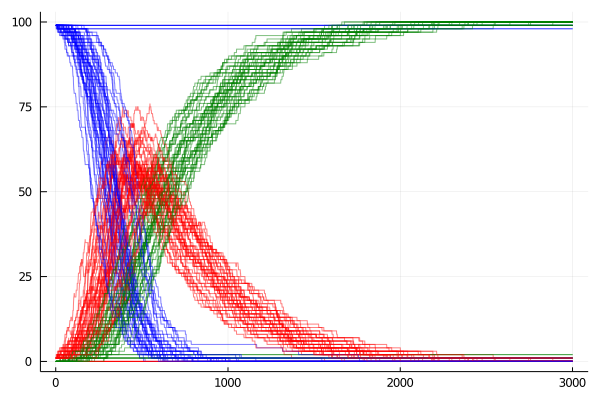

In [55]:
# 8. For the values of $p_I$ and $p_R$ that you found in [11], run 50 simulations. Plot $S$, $I$ and $R$ 
#    as a function of time for each of them (with transparency!).
L=20
N=100
p_I = 0.1
p_R = 0.01
n_sweeps = 3000
n_sim = 50

Ss_sim = []
Is_sim = []
Rs_sim = []
p = plot(fmt=:png, leg=false)
for i in 1:n_sim
    x = initialize(L, N);
    Ss, Is, Rs, state = dynamics!(x, L, p_I, p_R, n_sweeps)
    push!(Ss_sim, Ss)
    push!(Is_sim, Is)
    push!(Rs_sim, Rs)
    
    plot!(Ss, alpha=0.5, c="blue")
    plot!(Is, alpha=0.5, c="red")
    plot!(Rs, alpha=0.5, c="green")
end
p

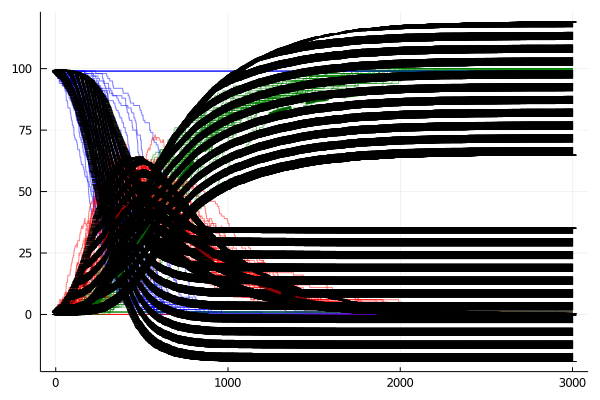

In [32]:
# 9. Plot their means with error bars.
#    You should see a result that looks like all those plots that you've seen of the SIR model on the 
#    internet. (If you haven't seen any, then what are you waiting for -- go and find some!) Except that 
#    they never show you error bars, even though error bars are clearly of the utmost importance.
Ss_sim_2D = hcat(Ss_sim...)
Is_sim_2D = hcat(Is_sim...)
Rs_sim_2D = hcat(Rs_sim...)

plot!(mean(Ss_sim_2D, dims=2), yerr=std(Ss_sim_2D, dims=2), lw=3, ls=:dash, c=:darkblue)
plot!(mean(Is_sim_2D, dims=2), yerr=std(Is_sim_2D, dims=2), lw=3, ls=:dash, c=:darkred)
plot!(mean(Rs_sim_2D, dims=2), yerr=std(Rs_sim_2D, dims=2), lw=3, ls=:dash, c=:darkgreen)

## Exercise 5 (Extra credit -- or for summer vacation): Social distancing

We can use a variant of the above model to investigate the effect of the totally mis-named "social distancing"
(we want people to be socially close, but physically distant).

In this variant, we separate out the two effects "infection" and "movement": an infected agent chooses a neighbouring site, and if it finds a susceptible there then it infects it with probability $p_I$.

Separately, an agent chooses a neighbouring site to move to, moves there with probability $p_M$ if the site is vacant. (Otherwise it stays where it is.)

In [41]:
# 1. When $p_M = 0$, the agents cannot move, and hence are completely quarantined in their original locations. 
#    Where can the disease spread in this case?
#    Run the dynamics repeatedly, looking at which sites become infected. (Draw them!)
#    How does this change as you increase the density $\rho = N / (L^2)$ of agents? Start with a small density.
#    This is basically the site percolation model.

function step_q!(agents::Vector{Agent}, L, p_I, p_R, p_M)

    N = length(agents)
    i = rand(1:N)
    agent_i = agents[i]
    proposed_position = jump(agent_i, L)
    if is_position_occupied(proposed_position, agents)
        j = find_agent_with_pos(proposed_position, agents)
        if (agents[i].status == I) & (agents[j].status == S) & (bernouli(p_I))
            agents[j].status = I
            agents[i].num_infected += 1
        end
        if (agents[i].status == I) & bernouli(p_R)
            agents[i].status = R
        end   
    else
        if bernouli(p_M) #Changes from step
            set_pos!(agent_i, proposed_position)
            agents[i] = agent_i 
        end
    end
        
    return agents
end

function sweep_q!(agents::Vector{Agent}, L, p_I, p_R, p_M) 
    for i in 1:length(agents)
        step_q!(agents, L, p_I, p_R, p_M)
    end
    return agents
end
#sweep!(x, L, p_I, p_R,)

function dynamics_q!(agents::Vector{Agent}, L, p_I, p_R, p_M, n_sweeps)
    state = []
    Ss = []
    Is = []
    Rs = []
    
    push!(state, deepcopy(agents))
    dict = countmap([i.status for i in agents])
    if haskey(dict, S) push!(Ss, dict[S]) else push!(Ss, 0) end
    if haskey(dict, I) push!(Is, dict[I]) else push!(Is, 0) end
    if haskey(dict, R) push!(Rs, dict[R]) else push!(Rs, 0) end
    
    for sweep_i in 1:n_sweeps
        sweep_q!(agents, L, p_I, p_R, p_M)
        push!(state, deepcopy(agents))
        dict = countmap([i.status for i in agents])
        if haskey(dict, S) push!(Ss, dict[S]) else push!(Ss, 0) end
        if haskey(dict, I) push!(Is, dict[I]) else push!(Is, 0) end
        if haskey(dict, R) push!(Rs, dict[R]) else push!(Rs, 0) end
    end
    
    return Ss, Is, Rs, state
end


L=10
N=200
x = initialize(L, N);
p_I = 0.1
p_R = 0.01
p_M = 0.05
n_sweeps = 10000
Ss, Is, Rs, state = dynamics_q!(x, L, p_I, p_R, p_M, n_sweeps)

@manipulate for n in slider(1:n_sweeps, value=1)
    p_1 = plot(fmt=:png, framestyle = :origin)
    plot!(p_1, [(L/2, L/2), (-L/2, L/2), (-L/2, -L/2), (L/2, -L/2), (L/2, L/2)], linestyle=:dash)
    visualize_agents(state[n+1], p_1)
    
    p_2 = plot(fmt=:png, ylim=(0, N), xlim=(0, n_sweeps))
    plot!(p_2, Ss[1:n], label="S")
    plot!(p_2, Is[1:n], label="I")
    plot!(p_2, Rs[1:n], label="R")
    
    hbox(p_1, p_2)
end

LoadError: InterruptException:

In [ ]:
# 2. When we start to increase $p_M$, we allow some local motion via random walk. 
#    Investigate how this leaky quarantine affects the infection dynamics with different densities.
